<a href="https://colab.research.google.com/github/ngzhankang/Deep-Learning/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
Submitted by : P1935727 Ng Zhan Kang<br>
Class of DIT/FT/2B/11


---
---

# 1.Setting Up Working Environment In Google Colab

### 1.1 Ensuring 0% Util

---

Ensure that our slot give by Google is not utilized yet.

In [1024]:
# to ensure that the current gpu utilization is 0
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize

import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 11.5 GB  | Proc size: 4.9 GB
GPU RAM Free: 11627MB | Used: 4653MB | Util  29% | Total 16280MB


### 1.2. Forcing Utils To 0% To Get A Clean Cluster

---

Please do not use this step unless the cluster you are allocated to is quite full.

In [1025]:
## if utilization is > 0, run this code(keep running this cell and the above cell till the util number is 0%):
## NOTE THAT RUNNING THIS MIGHT KILL GPU SESSION AND RESULT IN DATA LOSS(NOT ADVICABLE TO KEEP ON REUSING)
# !kill -9 -1

---
---

# 2.Ensuring GPU Is Utilized In Environment

### 2.1. See the list of available devices

---

This entire section can be omitted if users are not utilizing GPU at all.

In [1026]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16789160781209914590
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9548671142862532397
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11034519362755619500
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15695549568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8799179570456147180
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [1027]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [1028]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [1029]:
!nvidia-smi

Wed Nov 25 15:48:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |   4653MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

---
---

# 3.Background Information

## 3.1. About The MNIST Dataset
---

- BACKGROUND
  - The MNIST database of handwritten digits(Modified National Institute of Standards and Technology database) history came to existence in the late 1980s.
  - Also known as a "Hello World" exercise for people new to Neural Networks (or deep learning).
  - Was an extension of the NIST database, which the training dataset were handwriting originating from American Census Bureau employees, while the test dataset were handwriting taken from American high school students, also known as Special Dataset 3 and Special Dataset 1 respectively.
  - The creators of this dataset are **Yann LeCun, Corinna Cortes and Christopher J.C. Burges**.
  - The creators felt that NIST datasets was not well-suited for machine learning experiments since the origins of the train and test datasets **came from 2 different groups in the aforementioned point**. Furthermore, the black and white images from NIST were **normalized to fit into a 28 X 28 pixel bounding box and anti-aliased**, which introduced grayscale levels.
  - Contains **60,000 training and 10,000 testing images**. Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset.
  - Initially used **Support-Vector Machine** to get an error rate of 0.8%.
  - Was popular to build new government applications, including the US Department Of Defence, which wants to build an Automated Target Recognition (ATR) and also on the civilian side, from the postal service and IRAS to build an automated process of recognising handwritings for postcodes and others.


- BEST PERFORMANCES RECORDED
  - The current best record was made in 2018, by researches from Department of System and Information Engineering, University Of Virginia, which announced 0.18% error with simultaneous stacked three kind of neural networks (fully connected, recurrent and convolutional neural networks).
  - The original record as per written in [the MNIST dataset main website](http://yann.lecun.com/exdb/mnist/), was a test error rate of 12%, using 1 layer of linear classifier without any preprocessing at all.


- ARCHITECTURES
  - A notable deep neural network, called convolutional neural network, is a regularized version of multilayer perceptrons. It is one notable image classification algorithm, as it learns the filters, which traditionally were hand-engineered.
  - There are many architectures that make use of the basic CNN architecture and then improve on it. Examples are Neocognitron, the origin of CNN architecture, Time delay neural networks and CNN trained by gradient descent.
  - LeNet-5, or LeNet is also a architecture that originate from Yann LeCun. It is originally a system to recognise hand-written ZIP Code numbers involved convolutions in which the kernel coefficients had been laboriously hand designed. It usese a 7-level convolutional network that classifies digits, was applied by several banks to recognize hand-written numbers on cheques, digitized in 32x32 pixel images.

  - VGGNet was invented by VGG (Visual Geometry Group) from the University Of Oxford. It was a neural network which has proven significant improvement over ZFNet and AlexNet. It was one of the deep learning models that obtained less than 10% of error rate. It was trained on ImageNet dataset, a large dataset of annotated photographs intended for computer vision research. Pictures include cars, plant, flora, plant life, fungus, animal, etc. It have been proven effective for object recognition, but does not work properly for scenes recognition. Also, it uses alot of memory and is computationally time consuming.

  - AlexNet was primarily designed by Alex Krizhevsky, and was published with Ilya Sutskever and Krizhevsky's doctoral advisor Geoffrey Hinton, and is a Convolutional Neural Network or CNN. It achieved a top-5 error of 15.3% after competing in ImageNet Large Scale Visual Recognition Challenge, which was 10.8% lower than that of the runner up. It also, just like VGGNet, was trained on ImageNet dataset, and is meant for object recognition.


- GRAPHICAL IMAGE

  <img src="https://files.ifi.uzh.ch/ddis/teaching/bda/tensorflow_keras/img/mlp_1.png" alt="Graphical Image Of CNN with MNIST Dataset" title="MNIST database multilayer perceptron" />

## 3.2. Classic MNIST Dataset
---

- For this problem, create a CNN for image classification and evaluate the performance of the network
- Prepare the data and perform necessary feature engineering
- Create **_three models_**, which the scores should differ from one another significantly.
- Record down insights and reasonings.
- Form some conclusions.

---
---

# 4.Data Importing

### 4.1. Load the libraries

---

Import the necessary libraries.

In [1030]:
# Suppress Future Warnings
import warnings
warnings.filterwarnings('ignore')

In [1031]:
# check versions of libraries we are going to use
%tensorflow_version 2.x
import os
import tensorflow
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import platform

message="        Versions        "
print("*"*len(message))
print(message)
print("*"*len(message))
print("Tensorflow version={}".format(tensorflow.__version__))
print("Keras version={}".format(tensorflow.keras.__version__))
print("Sklearn version={}".format(sklearn.__version__))
print("Numpy version={}".format(np.__version__))
print("Pandas version={}".format(pd.__version__))
print("Seaborn version={}".format(sns.__version__))
print("Matplotlib version={}".format(matplotlib.__version__))
print("Python version={}".format(platform.python_version()))

************************
        Versions        
************************
Tensorflow version=2.3.0
Keras version=2.4.0
Sklearn version=0.22.2.post1
Numpy version=1.18.5
Pandas version=1.1.4
Seaborn version=0.11.0
Matplotlib version=3.2.2
Python version=3.6.9


In [1032]:
# download the necessary libraries that is not inside keras library
!pip install keras-adabound

# start importing necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, AveragePooling2D, Activation, BatchNormalization, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, History, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from keras_adabound import AdaBound

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

%matplotlib inline

In [1033]:
# fix random seed for reproducibility
np.random.seed(5)

In [1034]:
# get the dataset from keras library in tensorflow 2.0
mnist = tf.keras.datasets.mnist

# unpack the dataset to the respective x_train, y_train, x_test and y_test
(x_train, y_train), (x_test, y_test) = mnist.load_data()

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> MNIST Dataset includes handwritten digits from 0 to 9, and dimensions are 28 by 28 pixels. Each pixels is 8 bits, so its value ranges from to 0 to 255.<p>
</div>

### 4.2. Verify the dataset

---

Verify the credibility of the dataset first by plotting the 1st 25 images from the training set and display the class name below each image.

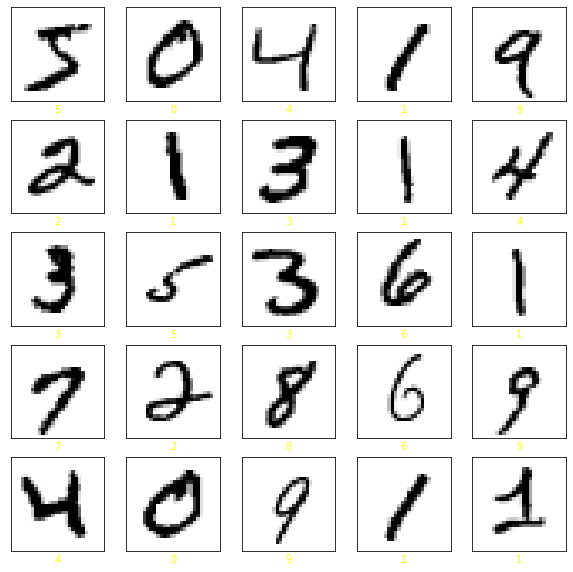

In [1035]:
# plot out some handwritings out so that we can see
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i], color="yellow")
plt.show()

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> It seems that the labels matches all the images, which is good! Now let's carry on to get a better insight of the datatset we are going to deal with.<p>
</div>

---
---

# 5.Exploratory Data Analysis

### 5.1. Basic Data Exploration

---

Take a peek look at what is inside the `x_train` and the `x_test`.

In [1036]:
# take a look at the x_train set first
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


In [1037]:
# take a look at the x_test set
print(x_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


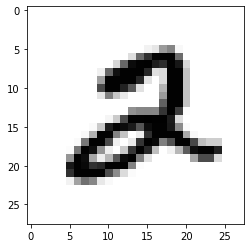

In [1038]:
# grab a random picture to take a look
plt.imshow(x_train[5], cmap=plt.cm.binary)
plt.show()

In [1039]:
# get the distinct lables that are found in the entire thing
print('Training set unique labels:',np.unique(y_train))
print('Test set unique labels:',np.unique(y_test))

Training set unique labels: [0 1 2 3 4 5 6 7 8 9]
Test set unique labels: [0 1 2 3 4 5 6 7 8 9]


In [1040]:
# get the count of the values from 0 to 9
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 5923]
 [   1 6742]
 [   2 5958]
 [   3 6131]
 [   4 5842]
 [   5 5421]
 [   6 5918]
 [   7 6265]
 [   8 5851]
 [   9 5949]]


Text(0.5, 1.0, 'Pixel Value Distribution')

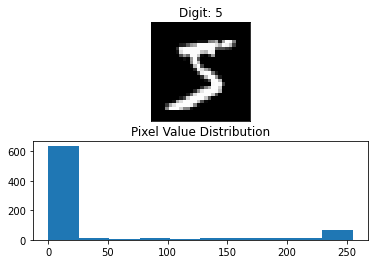

In [1041]:
# get the distribution of our pixel values
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(x_train[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(y_train[0]))
plt.xticks([])
plt.yticks([])

plt.subplot(2,1,2)
plt.hist(x_train[0].reshape(784))
plt.title("Pixel Value Distribution")

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> From what we can see, the pixel values ranges from 0 to 255, with the majority close to 0, and those close to 255 respresenting the digit.<p>
</div>

---
---

# 6.Feature Engineering

### 6.1. Changing Dimension To Match Keras Expectation

---

Reshape `x_train` and `x_test` to 4 dimensional array for the convolutional layer later on.

In [1042]:
# flatten 28*28 pixel images to 784 pixels for each image(from a 2D array to a 1D array)
num_pixels = x_train.shape[1] * x_train.shape[2]
X_train = x_train.reshape(x_train.shape[0], num_pixels).astype('float32')
X_test = x_test.reshape(x_test.shape[0], num_pixels).astype('float32')

# see the changes
print('New X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

New X_train shape: (60000, 784)
60000 train samples
10000 test samples


### 6.2. Normalize Training Data

---

Normalize the entire training dataset so that there is not much variation.

In [1043]:
# attempt to normalize the entire dataset first from 0-255 to 0-1
X_train /= 255
X_test /= 255

# see the shape of x_train and x_test first
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
60000 train samples
10000 test samples


### 6.3. Convert To Categorical Data

---

Convert the labels to categorical data as we do not want the model to think 9 has a higher priority than 0.

In [1044]:
# use to_categorical to convert the training and testing dataset labels
num_classes = 10 # number of classes (numbers 0 to 9)

Y_train = tf.keras.utils.to_categorical(y_train, num_classes)
Y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# now lets check again the training and test dataset labels
print('Y_train:', Y_train[0])
print('Y_test:', Y_test[0])

Y_train: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Y_test: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


### 6.4. Transforming to 1D array

---

We will change the numpy array to a 1D array so that we can feed inside our MLP models.

In [1045]:
# we are going to retain the original 1D shape and put in a new variable so that we will not mess up with the others
X_train_MLP = X_train
X_test_MLP = X_test

# examine the shape before we feed it in
print('New X_train_MLP shape:', X_train_MLP.shape)
print(X_train_MLP.shape[0], 'train samples')
print(X_test_MLP.shape[0], 'test samples')

New X_train_MLP shape: (60000, 784)
60000 train samples
10000 test samples


### 6.5. Transforming to 2D array

---

We will change the numpy array to a 2D array so that we can feed inside our CNN models.

In [1046]:
# reshape x_train and x_test to (n_images, x_shape, y_shape, channels)
# we are going to make chanels be 1 as we are not dealing with rgb images.
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# examine the shape before we feed it in
print('New X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

New X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


---
---

# 7.Models

### 7.1. Baseline MLP Model

---

First, we will setup a baseline model using a simple MLP architecture.

In [807]:
# create model and give it a name
model = Sequential(name="mlp_baseline_model")

# Layer 1 Fully Connected Layer (Hidden Layer)
model.add(Dense(350, kernel_initializer='normal', activation='relu', input_dim=num_pixels))

# Layer 2 Fully Connected Layer (Hidden Layer)
model.add(Dense(50, kernel_initializer='normal', activation='relu'))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()

Model: "mlp_baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_169 (Dense)            (None, 350)               274750    
_________________________________________________________________
dense_170 (Dense)            (None, 50)                17550     
_________________________________________________________________
dense_171 (Dense)            (None, 10)                510       
Total params: 292,810
Trainable params: 292,810
Non-trainable params: 0
_________________________________________________________________


In [808]:
# Configure the model and start training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_MLP, Y_train, epochs=10, batch_size=200, verbose=1, validation_split=0.2)

Epoch 1/10
240/240 [==============================] - 1s 3ms/step - loss: 0.3719 - accuracy: 0.8970 - val_loss: 0.1763 - val_accuracy: 0.9482
Epoch 2/10
240/240 [==============================] - 1s 3ms/step - loss: 0.1424 - accuracy: 0.9582 - val_loss: 0.1256 - val_accuracy: 0.9634
Epoch 3/10
240/240 [==============================] - 1s 3ms/step - loss: 0.0941 - accuracy: 0.9720 - val_loss: 0.0996 - val_accuracy: 0.9697
Epoch 4/10
240/240 [==============================] - 1s 3ms/step - loss: 0.0677 - accuracy: 0.9807 - val_loss: 0.0917 - val_accuracy: 0.9725
Epoch 5/10
240/240 [==============================] - 1s 3ms/step - loss: 0.0507 - accuracy: 0.9854 - val_loss: 0.0843 - val_accuracy: 0.9743
Epoch 6/10
240/240 [==============================] - 1s 3ms/step - loss: 0.0371 - accuracy: 0.9894 - val_loss: 0.0826 - val_accuracy: 0.9759
Epoch 7/10
240/240 [==============================] - 1s 3ms/step - loss: 0.0291 - accuracy: 0.9914 - val_loss: 0.0847 - val_accuracy: 0.9756
Epoch 

In [809]:
#print the available history keys for use
print(history.history.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


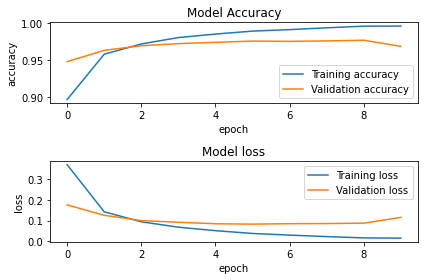

In [810]:
# plotting the accuracy and loss graphs
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='best')

plt.tight_layout()

### 7.2. Baseline CNN Model

---

First, we will setup a baseline model using a simple CNN architecture.

In [1047]:
# create model and give it a name
model = Sequential(name="sequential_baseline_model")

# Layer 1 Conv2D
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# Layer 2 Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3 Flatten Layer
model.add(Flatten())

# Layer 4 Fully Connected Layer (Hidden Layer)
model.add(Dense(100, kernel_initializer='he_uniform', activation='relu'))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()

Model: "sequential_baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_166 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_85 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_192 (Dense)            (None, 100)               540900    
_________________________________________________________________
dense_193 (Dense)            (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


In [1048]:
# implement a learning rate schedule in keras
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-08

adam = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

In [1049]:
# time to optimise the empty baseline model(an empty shell basically) and fit it with our training dataset
# passing params into the newly created model and compile it
model.compile(optimizer=adam,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# train the model
history = model.fit(X_train, Y_train, validation_split=0.2, epochs=15, batch_size=32, verbose=1)

Epoch 1/15
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1774 - accuracy: 0.9480 - val_loss: 0.0811 - val_accuracy: 0.9779
Epoch 2/15
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0599 - accuracy: 0.9816 - val_loss: 0.0601 - val_accuracy: 0.9819
Epoch 3/15
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0395 - accuracy: 0.9877 - val_loss: 0.0585 - val_accuracy: 0.9844
Epoch 4/15
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0278 - accuracy: 0.9910 - val_loss: 0.0529 - val_accuracy: 0.9842
Epoch 5/15
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0177 - accuracy: 0.9945 - val_loss: 0.0576 - val_accuracy: 0.9847
Epoch 6/15
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0130 - accuracy: 0.9962 - val_loss: 0.0589 - val_accuracy: 0.9854
Epoch 7/15
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0106 - accuracy: 0.9969 - val_loss: 0.0579 - val_accuracy:

In [1050]:
#print the available history keys for use
print(history.history.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


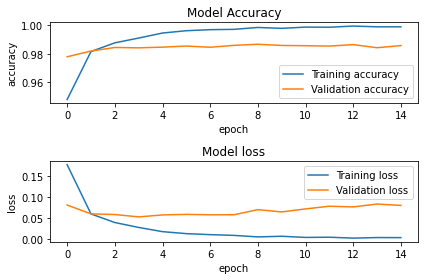

In [1051]:
# plotting the accuracy and loss graphs
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='best')

plt.tight_layout()

### 7.3. LeNet-5 CNN Model

---

Next, we will setup a CNN Model with abit of changes to the  LeNet-5 architecture.

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> We  understand that there are a few main reasons for overfitting in Neural Networks. They are mainly due to the network size, lack of weight regularization and lack of dropouts. In order to reduce (or to  prevent this from happenening), we will implement these 3 main points. Here we will implement the modified LeNet-5 Architecture to test out how precise the overall architecture is incuding some of the additional features i feel it is important.<p>
</div>

In [898]:
# create model and give it a name
model = Sequential(name="lenet5_cnn_model_sequential")

# Layer 1 Conv2D
model.add(Conv2D(filters=150, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(28, 28, 1), padding='same'))
model.add(BatchNormalization())
# Layer 2 Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 3 Conv2D
model.add(Conv2D(filters=140, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
model.add(BatchNormalization())
# Layer 4 Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 5 Flatten
model.add(Flatten())

# Layer 6 Fully Connected Layer (Hidden Layer)
model.add(Dense(units=120, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=num_classes, activation='softmax'))

# get model summary
model.summary()

Model: "lenet5_cnn_model_sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_148 (Conv2D)          (None, 28, 28, 150)       3900      
_________________________________________________________________
batch_normalization_142 (Bat (None, 28, 28, 150)       600       
_________________________________________________________________
average_pooling2d_142 (Avera (None, 14, 14, 150)       0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 10, 10, 140)       525140    
_________________________________________________________________
batch_normalization_143 (Bat (None, 10, 10, 140)       560       
_________________________________________________________________
average_pooling2d_143 (Avera (None, 5, 5, 140)         0         
_________________________________________________________________
flatten_76 (Flatten)         (None, 350

In [899]:
# time to optimise the empty CNN model(an empty shell basically) and fit it with our training dataset
# passing params into the newly created model and compile it
model.compile(optimizer=AdaBound(lr=1e-3, final_lr=0.1),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# train the model
history = model.fit(X_train,Y_train, validation_split=0.2, batch_size=16, epochs=15, verbose=1)

Epoch 1/15
3000/3000 [==============================] - 19s 6ms/step - loss: 0.1430 - accuracy: 0.9590 - val_loss: 0.0591 - val_accuracy: 0.9832
Epoch 2/15
3000/3000 [==============================] - 19s 6ms/step - loss: 0.0514 - accuracy: 0.9853 - val_loss: 0.0685 - val_accuracy: 0.9859
Epoch 3/15
3000/3000 [==============================] - 19s 6ms/step - loss: 0.0339 - accuracy: 0.9903 - val_loss: 0.0379 - val_accuracy: 0.9908
Epoch 4/15
3000/3000 [==============================] - 19s 6ms/step - loss: 0.0207 - accuracy: 0.9939 - val_loss: 0.0364 - val_accuracy: 0.9908
Epoch 5/15
3000/3000 [==============================] - 19s 6ms/step - loss: 0.0169 - accuracy: 0.9948 - val_loss: 0.0413 - val_accuracy: 0.9911
Epoch 6/15
3000/3000 [==============================] - 19s 6ms/step - loss: 0.0134 - accuracy: 0.9959 - val_loss: 0.0412 - val_accuracy: 0.9908
Epoch 7/15
3000/3000 [==============================] - 19s 6ms/step - loss: 0.0088 - accuracy: 0.9972 - val_loss: 0.0367 - val_ac

In [900]:
#print the available history keys for use
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


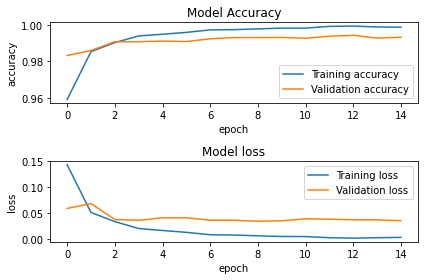

In [901]:
# plotting the accuracy and loss graphs
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='best')

plt.tight_layout()

### 7.4. LeNet-5 CNN Hyper-Parameter Tuned Model

---

Next, we will setup a LeNet-5 CNN Hyper Parameter Tuned Model that has undergone hyper-parameter tuning.

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> Now from our 2nd model, it seems that the accuracy score is around 99%, and the model loss is now less than 1%, which is a good indicator that it is a good architecture. Now, we will perform hyper-parameter tuning with some more inclusions like l1 l2 regularizers on top of the 2nd model architecture. We will try to use SGD here as our optimizer. Firstly, we will do a gridsearch to get the best parameter for the weight initializer. After we get the results, we will then proceed on to fit into the model. In the process, i will use GridSearchCV to tune the hyperparameter.<p>
</div>

In [1018]:
# create a function that creates a model which is required for KerasClassifier so that we can tune hyperparams using cross validation
def create_model(init_mode='uniform'):
  # define model here

  # Instantiate a Sequential model
  model = Sequential(name="cnn_model_hyperParamTuned_sequential_LeNet")

  # Layer 1 Conv2D
  model.add(Conv2D(filters=150, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(28, 28, 1), padding='same'))
  model.add(BatchNormalization())
  # Layer 2 Pooling Layer
  model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

  # Layer 3 Conv2D
  model.add(Conv2D(filters=140, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
  model.add(BatchNormalization())
  # Layer 4 Pooling Layer
  model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

  # Layer 5 Flatten
  model.add(Flatten())

  # Layer 6 Fully Connected Layer (Hidden Layer)
  model.add(Dense(units=120, activation='relu'))
  model.add(Dropout(0.2))

  # Output layer
  model.add(Dense(units=num_classes, activation='softmax'))

  # passing params into the newly created model and compile it
  model.compile(optimizer='sgd',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

  return model

In [1019]:
# call the model
model = create_model()

# get the summary of the
model.summary()

Model: "cnn_model_hyperParamTuned_sequential_LeNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_162 (Conv2D)          (None, 28, 28, 150)       3900      
_________________________________________________________________
batch_normalization_156 (Bat (None, 28, 28, 150)       600       
_________________________________________________________________
average_pooling2d_156 (Avera (None, 14, 14, 150)       0         
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 10, 10, 140)       525140    
_________________________________________________________________
batch_normalization_157 (Bat (None, 10, 10, 140)       560       
_________________________________________________________________
average_pooling2d_157 (Avera (None, 5, 5, 140)         0         
_________________________________________________________________
flatten_83 (Flatten)    

In [1020]:
# declare decay_rate and learning_rate here
learning_rate = 0.1 
decay_rate = 0.1

# define the learning rate change 
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate
    
# learning schedule callback
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [lr_rate]

In [1021]:
# let early stopping terminate the training process
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [1022]:
# fit into KerasClassifier
model_CV = KerasClassifier(create_model)

# define the search parameter
param_grid = {
    'init_mode': ['uniform','normal','glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
}

# fit it into RandomizedSearchCV 
model = RandomizedSearchCV(model_CV, param_grid, scoring='accuracy', n_iter=3, cv=3, verbose=True) #do not put n_jobs when using gpu

In [1023]:
# train the model
history = model.fit(X_train, Y_train, epochs=15, validation_data=(X_test, Y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=5), callbacks_list])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Epoch 1/15


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1250/1250 [==============================] - 6s 5ms/step - loss: 0.1938 - accuracy: 0.9455 - val_loss: 0.0532 - val_accuracy: 0.9835
Epoch 2/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0591 - accuracy: 0.9825 - val_loss: 0.0329 - val_accuracy: 0.9893
Epoch 3/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0385 - accuracy: 0.9880 - val_loss: 0.0467 - val_accuracy: 0.9858
Epoch 4/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0271 - accuracy: 0.9917 - val_loss: 0.0275 - val_accuracy: 0.9913
Epoch 5/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0197 - accuracy: 0.9938 - val_loss: 0.0303 - val_accuracy: 0.9898
Epoch 6/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0150 - accuracy: 0.9955 - val_loss: 0.0249 - val_accuracy: 0.9926
Epoch 7/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0121 - accuracy: 0.9962 - val_loss: 0.0212 - val_accuracy: 0.9937
Epo

ValueError: ignored

In [ ]:
# print results for the best param grid
print(f'Best Accuracy for {history.best_score_} using {history.best_params_}')
means = history.cv_results_['mean_test_score']
stds = history.cv_results_['std_test_score']
params = history.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.9914166629314423 using {'init_mode': 'normal'}
 mean=0.991, std=0.0 using {'init_mode': 'uniform'}
 mean=0.9914, std=0.0003833 using {'init_mode': 'normal'}
 mean=0.9912, std=0.0004334 using {'init_mode': 'glorot_normal'}
 mean=0.9912, std=0.0006167 using {'init_mode': 'glorot_uniform'}
 mean=0.9912, std=0.00025 using {'init_mode': 'he_normal'}
 mean=0.9908, std=0.0004167 using {'init_mode': 'he_uniform'}


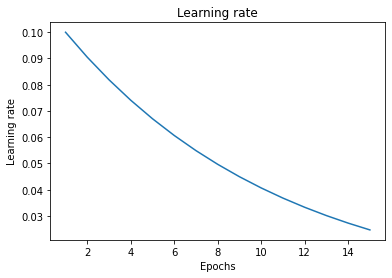

In [ ]:
# plot learning rate curve
learning_rate = history.best_estimator_.model.history.history['lr']
epochs = range(1, len(learning_rate) + 1)
plt.plot(epochs, learning_rate)
plt.title('Learning rate')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.show()

In [ ]:
#print the available history keys for use
print(history.best_estimator_.model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


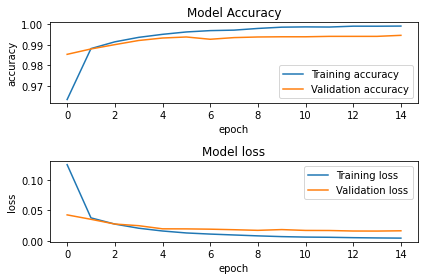

In [ ]:
# plotting the accuracy and loss graphs
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.best_estimator_.model.history.history['accuracy'])
plt.plot(history.best_estimator_.model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')

plt.subplot(2,1,2)
plt.plot(history.best_estimator_.model.history.history['loss'])
plt.plot(history.best_estimator_.model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='best')

plt.tight_layout()

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> From here, we can see that the best weight initializer is normal with an accuracy score of 0.9914166629314423. So what we shall do right now is to use that initializer and refit it into a new model as we cannot use that to evaluate our loss and accuracy using the keras evaluate method. Here, we shall also go and use our ImageDataGenerator and see if we can improve the loss and accuracy score. We will add in some "stabilizers" like l2 to prevent overfitting and save our model, so that we need not re-run and wait for friggin long time. Also, please re-run from the beginning again before executing from this point onwards.<p>
</div>

In [ ]:
# Instantiate a Sequential model
model = Sequential(name="cnn_model_hyperParamTuned_sequential_LeNet")

# Layer 1 Conv2D
model.add(Conv2D(filters=150, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(28, 28, 1), padding='same'))
model.add(BatchNormalization())
# Layer 2 Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 3 Conv2D
model.add(Conv2D(filters=140, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
model.add(BatchNormalization())
# Layer 4 Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 5 Flatten
model.add(Flatten())

# Layer 6 Fully Connected Layer (Hidden Layer)
model.add(Dense(units=120, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(0.2)))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=num_classes, activation='softmax'))

# get model summary
model.summary()

Model: "cnn_model_hyperParamTuned_sequential_LeNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 28, 28, 150)       3900      
_________________________________________________________________
batch_normalization_30 (Batc (None, 28, 28, 150)       600       
_________________________________________________________________
average_pooling2d_30 (Averag (None, 14, 14, 150)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 10, 10, 140)       525140    
_________________________________________________________________
batch_normalization_31 (Batc (None, 10, 10, 140)       560       
_________________________________________________________________
average_pooling2d_31 (Averag (None, 5, 5, 140)         0         
_________________________________________________________________
flatten_15 (Flatten)    

In [ ]:
# passing params into the newly created model and compile it
model.compile(optimizer='sgd',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

In [ ]:
# declare decay_rate and learning_rate here
learning_rate = 0.1 
decay_rate = 0.1

# define the learning rate change 
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate
    
# learning schedule callback
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [lr_rate]

In [ ]:
# we shall do some ImageDataGenerator here to augment the input data, which can help prevent over-fitting as we augment the images
datagen = ImageDataGenerator(
    rotation_range=8,
    shear_range=0.3,
    zoom_range=0.08,
    width_shift_range=0.08,
    height_shift_range=0.08,
    rescale=1.1
)

In [ ]:
# fit the generator to the data first before training
datagen.fit(X_train)

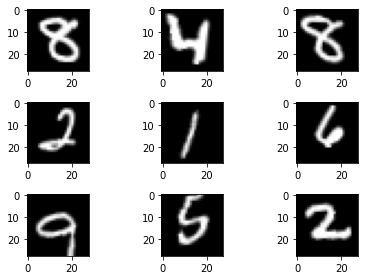

In [ ]:
# preview our augmented images here
for X_batch, Y_batch in datagen.flow(X_train, Y_train, batch_size=60000):
  for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_batch[i].reshape(28, 28), cmap=('gray'))
  plt.tight_layout()
  plt.show()
  break

# concatenate the augmented data into a numpy array
augmented_data_X_train = np.concatenate((X_train, X_batch))
augmented_data_Y_train = np.concatenate((Y_train, Y_batch))

In [ ]:
# train the model(we use .fit since .fit_generator is depreciated already)
history = model.fit(augmented_data_X_train,
                    augmented_data_Y_train,
                    batch_size=640,
                    epochs=60,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5), callbacks_list],
                    validation_data=(X_test, Y_test),
                    verbose=1)

Epoch 1/60
188/188 [==============================] - 18s 97ms/step - loss: 14.8874 - accuracy: 0.8699 - val_loss: 0.2597 - val_accuracy: 0.9730
Epoch 2/60
188/188 [==============================] - 18s 96ms/step - loss: 0.2502 - accuracy: 0.9630 - val_loss: 0.1822 - val_accuracy: 0.9799
Epoch 3/60
188/188 [==============================] - 18s 97ms/step - loss: 0.1970 - accuracy: 0.9716 - val_loss: 0.1371 - val_accuracy: 0.9867
Epoch 4/60
188/188 [==============================] - 18s 97ms/step - loss: 0.1639 - accuracy: 0.9779 - val_loss: 0.1251 - val_accuracy: 0.9859
Epoch 5/60
188/188 [==============================] - 18s 97ms/step - loss: 0.1467 - accuracy: 0.9803 - val_loss: 0.1607 - val_accuracy: 0.9728
Epoch 6/60
188/188 [==============================] - 18s 97ms/step - loss: 0.1333 - accuracy: 0.9826 - val_loss: 0.1001 - val_accuracy: 0.9909
Epoch 7/60
188/188 [==============================] - 18s 97ms/step - loss: 0.1247 - accuracy: 0.9832 - val_loss: 0.0965 - val_accuracy

In [ ]:
#print the available history keys for use
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


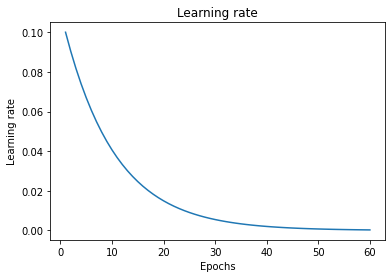

In [ ]:
# plot learning rate curve
learning_rate = history.history['lr']
epochs = range(1, len(learning_rate) + 1)
plt.plot(epochs, learning_rate)
plt.title('Learning rate')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.show()

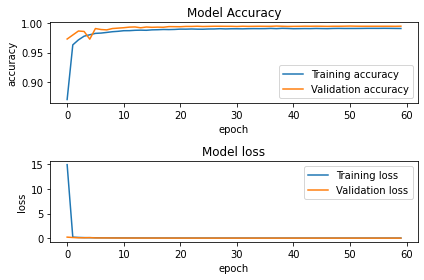

In [ ]:
# plotting the accuracy and loss graphs
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='best')

plt.tight_layout()

---
---

# 8.Test Accuracy, Loss And Results

### 8.1. MLP Baseline Model Result

---

Get the result for the MLP baseline model.

In [811]:
# now we shall evaluate the model and see the accuracy
loss, accuracy = model.evaluate(X_test_MLP,Y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("MLP Baseline Model Accuracy: %.2f%%" % (accuracy*100))
print("MLP Baseline Model Error: %.2f%%" % (100-accuracy*100))

313/313 [==============================] - 1s 2ms/step - loss: 0.0982 - accuracy: 0.9725
Test loss: 0.09824369102716446
Test accuracy: 0.9725000262260437
MLP Baseline Model Accuracy: 97.25%
MLP Baseline Model Error: 2.75%


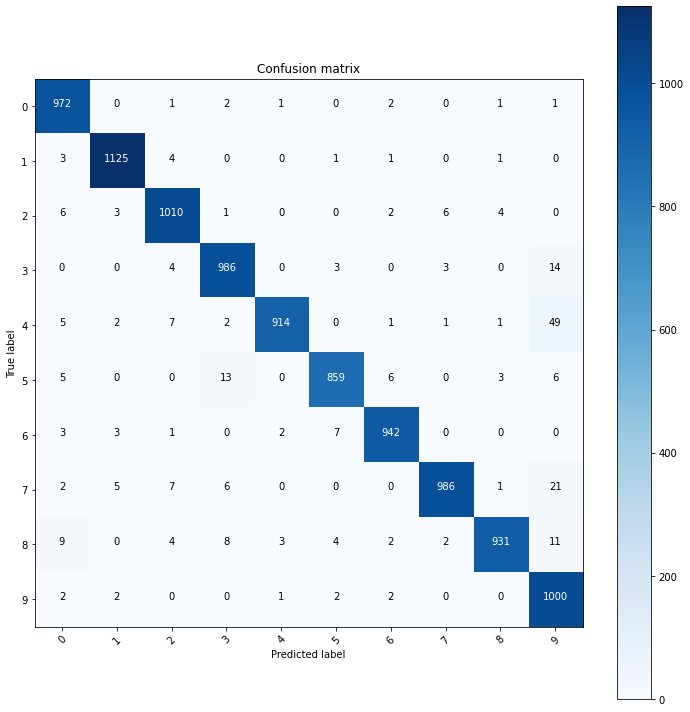

In [812]:
# plot our confusion matrix here to see how many labels got misplaced
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10)) # Set Figure
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test_MLP)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


9725  classified correctly
275  classified incorrectly


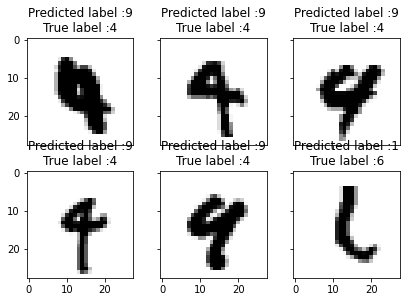

In [813]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test_MLP[errors]

# see which we predicted correctly and which not
correct_indices = np.nonzero(Y_pred_classes == y_test)[0]
incorrect_indices = np.nonzero(Y_pred_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    plt.tight_layout()
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=plt.cm.binary)
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

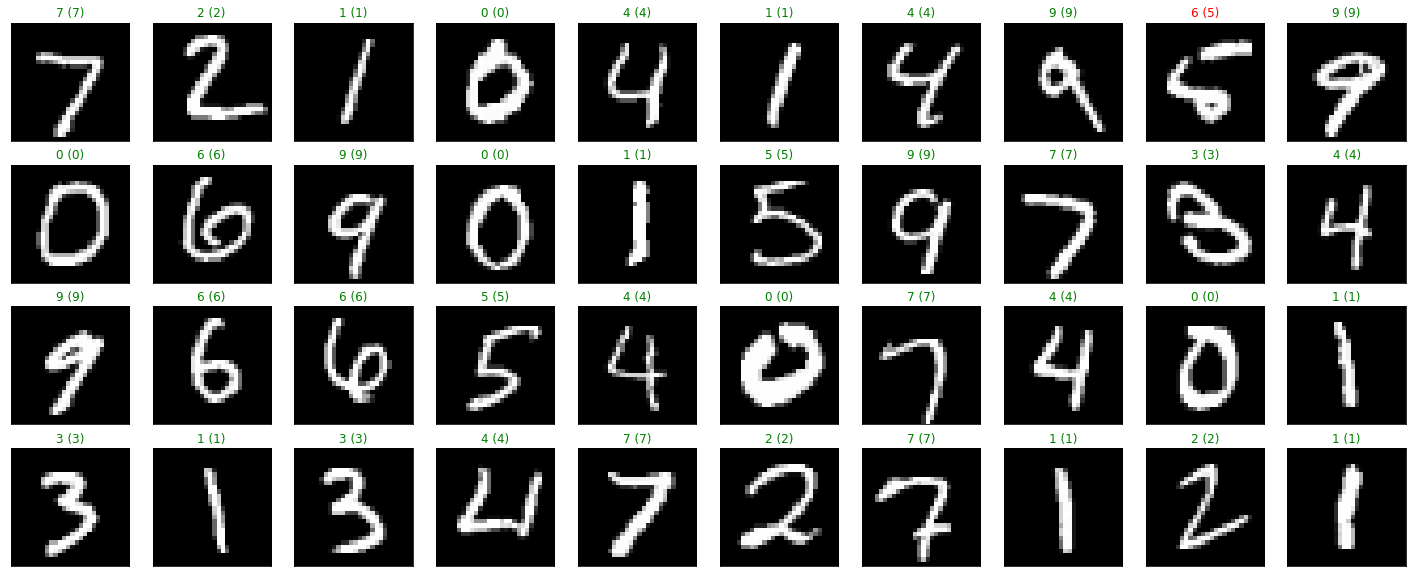

In [819]:
# obtain 40 test images
images, labels = X_test_MLP[:40], Y_test[:40]

# get sample outputs
predict = model.predict_on_batch(images)
# convert output probabilities to predicted class
preds = np.argmax(predict, axis=1)
labels = np.argmax(labels, axis=1)

# plot the images in the batch, along with predicted and true labels (brackets is true label), non bracket is predicted.
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(40):
    ax = fig.add_subplot(4, 40/4, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].reshape((28, 28)), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### 8.2. Baseline Model Result

---

Get the result for the baseline model.

In [1052]:
# now we shall evaluate the model and see the accuracy
loss, accuracy = model.evaluate(X_test,Y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Baseline Model Accuracy: %.2f%%" % (accuracy*100))
print("Baseline Model Error: %.2f%%" % (100-accuracy*100))

313/313 [==============================] - 1s 2ms/step - loss: 0.0717 - accuracy: 0.9848
Test loss: 0.07168284058570862
Test accuracy: 0.9847999811172485
Baseline Model Accuracy: 98.48%
Baseline Model Error: 1.52%


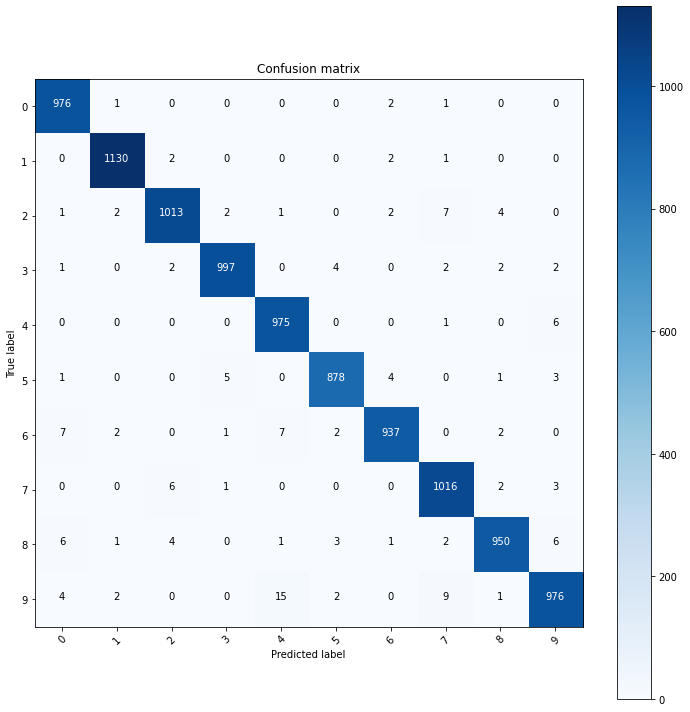

In [1053]:
# plot our confusion matrix here to see how many labels got misplaced
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10)) # Set Figure
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


9848  classified correctly
152  classified incorrectly


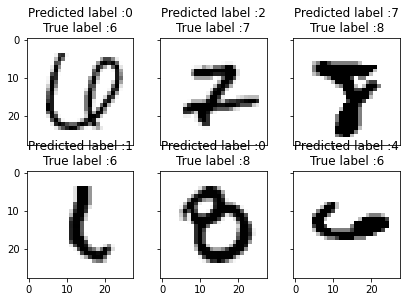

In [1054]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

# see which we predicted correctly and which not
correct_indices = np.nonzero(Y_pred_classes == y_test)[0]
incorrect_indices = np.nonzero(Y_pred_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    plt.tight_layout()
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=plt.cm.binary)
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

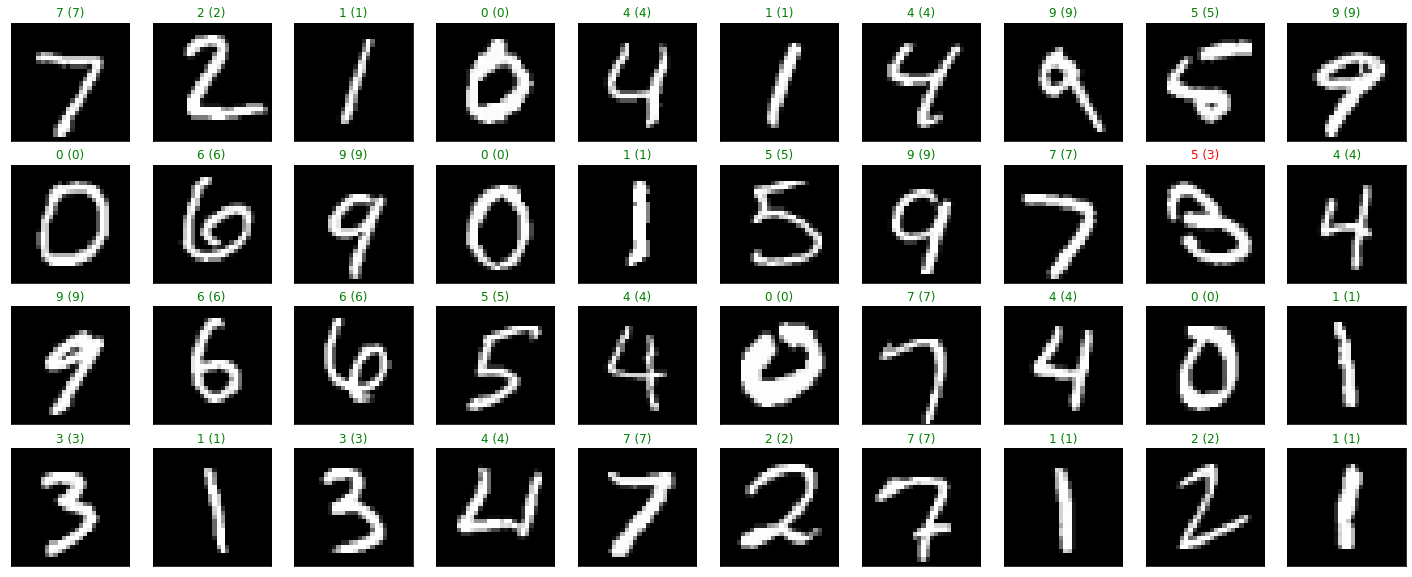

In [1055]:
# obtain 40 test images
images, labels = X_test[:40], Y_test[:40]

# get sample outputs
predict = model.predict_on_batch(images)
# convert output probabilities to predicted class
preds = np.argmax(predict, axis=1)
labels = np.argmax(labels, axis=1)

# plot the images in the batch, along with predicted and true labels (brackets is true label), non bracket is predicted.
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(40):
    ax = fig.add_subplot(4, 40/4, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].reshape((28, 28)), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### 8.3. LeNet-5 CNN Model Result

---

Get the result for the CNN model.

In [902]:
# now we shall evaluate the model and see the accuracy
loss, accuracy = model.evaluate(X_test,Y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("CNN Model Accuracy: %.2f%%" % (accuracy*100))
print("CNN Model Error: %.2f%%" % (100-accuracy*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.0299 - accuracy: 0.9934
Test loss: 0.02986971102654934
Test accuracy: 0.993399977684021
CNN Model Accuracy: 99.34%
CNN Model Error: 0.66%


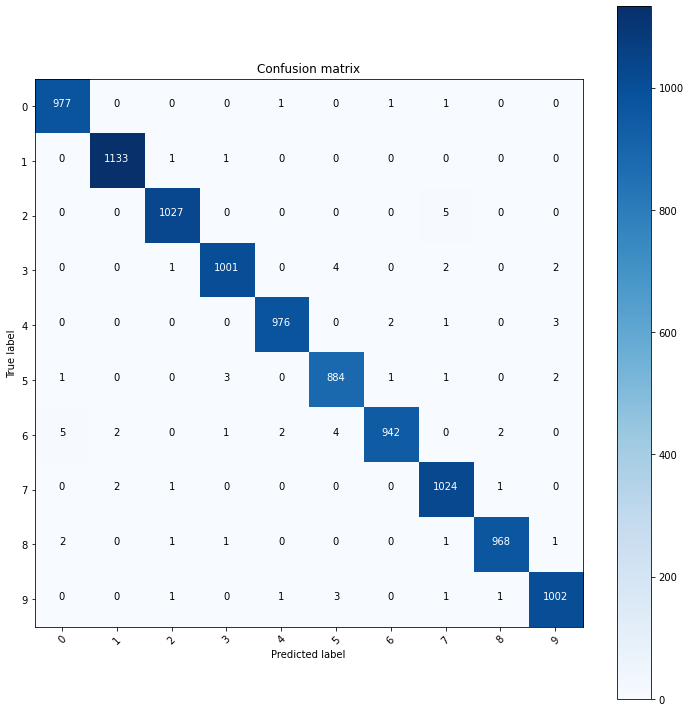

In [903]:
# plot our confusion matrix here to see how many labels got misplaced
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10)) # Set Figure
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


9934  classified correctly
66  classified incorrectly


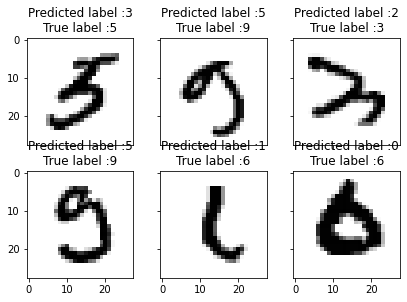

In [906]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

# see which we predicted correctly and which not
correct_indices = np.nonzero(Y_pred_classes == y_test)[0]
incorrect_indices = np.nonzero(Y_pred_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    plt.tight_layout()
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=plt.cm.binary)
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

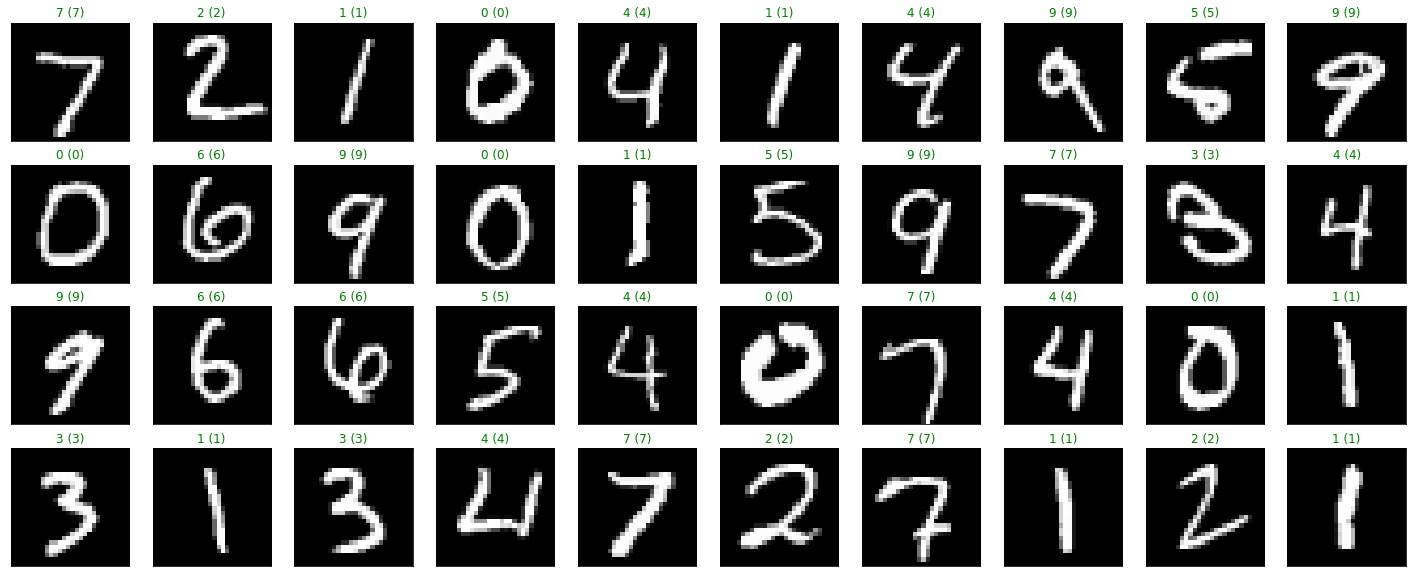

In [905]:
# obtain 40 test images
images, labels = X_test[:40], Y_test[:40]

# get sample outputs
predict = model.predict_on_batch(images)
# convert output probabilities to predicted class
preds = np.argmax(predict, axis=1)
labels = np.argmax(labels, axis=1)

# plot the images in the batch, along with predicted and true labels (brackets is true label), non bracket is predicted.
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(40):
    ax = fig.add_subplot(4, 40/4, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].reshape((28, 28)), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### 8.4. CNN Hyper-Parameter Tuned Model Result

---

Get the result for the CNN model that has undergone hyper parameter tuning.

In [ ]:
# now we shall evaluate the model and see the accuracy(do not use X_val and Y_val)
loss, accuracy = model.evaluate(X_test,Y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("CNN Hyper-Parameter Tuned Model Accuracy: %.2f%%" % (accuracy*100))
print("CNN Hyper-Parameter Tuned Model Error: %.2f%%" % (100-accuracy*100))

313/313 [==============================] - 1s 4ms/step - loss: 0.0586 - accuracy: 0.9949
Test loss: 0.058558784425258636
Test accuracy: 0.9948999881744385
CNN Hyper-Parameter Tuned Model Accuracy: 99.49%
CNN Hyper-Parameter Tuned Model Error: 0.51%


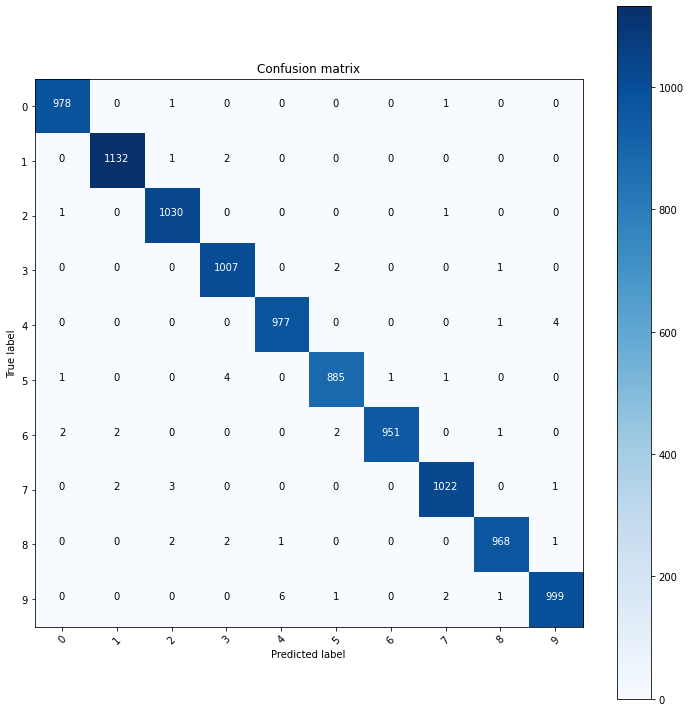

In [ ]:
# plot our confusion matrix here to see how many labels got misplaced
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10)) # Set Figure
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


9949  classified correctly
51  classified incorrectly


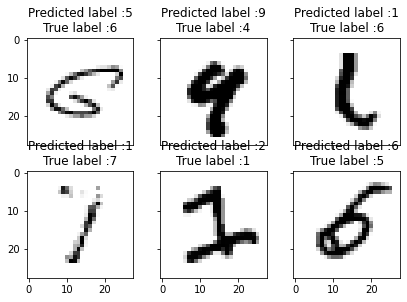

In [ ]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

# see which we predicted correctly and which not
correct_indices = np.nonzero(Y_pred_classes == y_test)[0]
incorrect_indices = np.nonzero(Y_pred_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    plt.tight_layout()
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=plt.cm.binary)
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

---
---

# 9.Conclusions

-	How is your prediction task defined? And what is the meaning of the output variable?
    - __The prediction task is defined as to predict if the handwritten digit issued matches the label for it. The output variable is the prediction of the correct label (from digits 0 to 9) for the respective handwritten images.__

-	How is the data represented as features?
    - __In the MNIST dataset, it contains 60,000 training cases and 10,000 test cases of handwritten digits from 0 to 9. Each image consists of 784 pixels that represent the features of the digits.__

-	Did you process the features in any way (e.g. normalization)?
    - __Yes. Firstly, i normalized the training dataset by dividing `X_train` and `X_test` with 255, as each value is between 0-255 (single greyscale) so that the values are between 0 and 1. I then went on to do `onehotencoding` on the labels as we do not want the model to think 9 has a higher priority than 0. I also converted it into a 2D array so that the data can be fed into the convolutional layer when i do the model.__

-	How did you select which CNN architecture to use?
    - __After doing some research, i found out some well-know CNN models 2 decades ago and some that were created not long ago. As per what i have shared in the background information at the top of the entire notebook, they are the AlexNet, the VGGNet and the LeNet-5 architectures. The AlexNet and the VGGNet both uses the ImageNet dataset to train the architectures although they are also made using the CNN architecture. However, LenNet-5, created by one of the founding fathers of MNIST handwritten dataset, was used to distinguish handwritten digits and digital digits on postmails, and have a different objective to its other 2 counterparts. Also, i have initially tested out AlexNet architecture and the loss was not desirable. Therefore, i have decided to inherit the core architecture from LeNet-5 architecture.__

-	How did you evaluate the quality of your system?
    - __There are 4 main methods which i use to evaluate the quality of my system. Firstly i plotted out a model accuracy and model loss graph to firstly determine if overfitting has occured in my model or not. Next, i use keras `.evaluate()` to see the test loss, accuracy, model errror and model accuracy. I also plotted out a confusion matrix to see the labels and true labels of the correctly distinguised digits and those which are wrong. I also plotted out to show the top 6 wrongly classified digits, and the number of correctly classified digits.__

-	Can you say anything about the errors that the system makes? You may consider a confusion matrix.
    - __Yes. So i will begin talking from the 1st model to the 3rd model of the confusion matrix of the 3 models. From the 1st model, we can see that although most of the digits are correctly classified to their true labels, but we can see alot of misclassified digits of 8 that are labelled as 3 instead. We also can see that 12 numbers of 3 were misclassified as 5, and 16 digits of 9 were misclassified as 4. And in total, we have around 213 labels classified wrongly.__ 
    
      __Moving on to model 2, we can see that also most of the digits are correctly classified, with 7 wrongly classified true label of 3 being classified as 5, and 6 numbers of 9 being misclassified as 4. In total, we have around 73 labels classified wrongly.__
        
      __Finally, when we evaluate our final model, we see that at most 7 digits of 9 has been misclassified as 4, with a few negligible ones. In total, we have around 55 labels classified wrongly.__

- Please show how you have improved the model from the inital performance, e.g. by hyperparemeter tuning, by modifying the network architecture, or by introducting regularization using Dropout, etc.?
    - __I used KerasClassifier and GridSearchCV from keras and sklearn respectively. I used both to find out what is the best weight initalizer for the full connected layer. In the end, i noticed that `normal` is the best weight initializer instead of the default `glorot_uniform`. I then proceed on to add in the kernal_regularizer with a l2 penalty to prevent overfititng. I also added a keras `LearningRateScheduler` to adjust the learning rate as the number of epochs increases. I also did image augmentation using keras `ImageDataGenerator` by taking some training dataset and modifying the images. All methods aids in preventing the model from overfitting, and also partiall improving the score.__

     __Eventually, we can see that we have a model accuracy of 99.45% and a recorded model error of 0.55%. Our test loss is 0.03955. Comparing it with our second model, we can see that our model 2 have a model accuracy of 99.27%, with model error at 0.73% and a test loss of 0.02392. Finally, comparing it with our initial CNN model, we only had a model accuracy of 97.87%, a model error of 2.13% and recorded test loss of 0.1735.__

-	Provide a reference section for any papers, online articles, books, publications that you may have referenced?
    - __In the MNIST dataset, it contains 60,000 training cases and 10,000 test cases of handwritten digits from 0 to 9. Each image consists of 784 pixels that represent the features of the digits.__

---
---

# 10.References


## Using Google Colab More Efficiently
---
1. [Getting the Most Out of Your Google Colab (Tutorial)](https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403)
2. [Using Google Colab with GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)


## Background Research
---
1. [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
2. [LeNet](https://en.wikipedia.org/wiki/LeNet)
3. [The MNIST Database of handwritten digits](http://yann.lecun.com/exdb/mnist/)
4. [LeCun et al. (1999): The MNIST Dataset Of Handwritten Digits (Images)](http://www.pymvpa.org/datadb/mnist.html)
5. [MNIST Dataset](https://deepai.org/dataset/mnist)
6. [MNIST Dataset- Wikipedia](https://en.wikipedia.org/wiki/MNIST_database)
7. [The Story of the MNIST Dataset](https://www.youtube.com/watch?v=oKzNUGz21JM&ab_channel=LanderAnalytics)
8. [AlexNet: The First CNN to win Image Net](https://www.mygreatlearning.com/blog/alexnet-the-first-cnn-to-win-image-net/#:~:text=AlexNet%20was%20primarily%20designed%20by,%2D5%20error%20of%2015.3%25.)
9. [VGG Net](https://en.everybodywiki.com/VGG_Net)


## Selecting CNN Architecture
---
1. [Top 10 CNN Architecture](https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d#676b)
2. [AlexNet: The Architecture that Challenged CNNs](https://towardsdatascience.com/alexnet-the-architecture-that-challenged-cnns-e406d5297951)
3. [How to choose CNN Architecture MNIST](https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist#What-is-the-best-CNN-architecture-for-MNIST?)
4. [Convolutional Neural Network Champions —Part 1: LeNet-5 (TensorFlow 2.x)](https://towardsdatascience.com/convolutional-neural-network-champions-part-1-lenet-5-7a8d6eb98df6)
5. [Understanding and Implementing LeNet-5 CNN Architecture (Deep Learning)](https://towardsdatascience.com/understanding-and-implementing-lenet-5-cnn-architecture-deep-learning-a2d531ebc342)
6. [Dense or Convolutional Neural Network](https://medium.com/analytics-vidhya/dense-or-convolutional-part-1-c75c59c5b4ad)


## Some Tutorials on how to build a CNN Model
---
1. [Building a Custom Convolutional Neural Network in Keras](https://medium.com/@ODSC/building-a-custom-convolutional-neural-network-in-keras-48171163aa7f)
2. [The Most Intuitive and Easiest Guide for Convolutional Neural Network](https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480)
3. [MNIST with Keras for Beginners(.99457)](https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457)
4. [Introduction to CNN Keras - Acc 0.997 (top 8%)](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)
5. [Image Classification in 10 Minutes with MNIST Dataset](https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d)
6. [How to Develop a CNN for MNIST Handwritten Digit Classification](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/#:~:text=The%20MNIST%20dataset%20is%20an,digits%20between%200%20and%209.)
7. [MNIST Handwritten Digit Recognition in Keras](https://nextjournal.com/gkoehler/digit-recognition-with-keras)
8. [mnist keras early stopping](https://www.kaggle.com/ahmetkorkmaz/mnist-keras-early-stopping)
9. [Applying Convolutional Neural Network on the MNIST dataset](https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/)


## Feature Engineering
---
1. [Why Change Data Dimension Before Feeding Into Keras?](https://stackoverflow.com/a/62991238/12347869)
2. [Properly Setting the Random Seed in ML Experiments. Not as Simple as You Might Imagine](https://medium.com/@ODSC/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752)
3. [How to get reproducible results in keras](https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras)
4. [How can I obtain reproducible results using Keras during development?](https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development)


## Building Layers
---
1. [What is the default weight initializer in Keras?](https://stackoverflow.com/questions/54011173/what-is-the-default-weight-initializer-in-keras)
2. [A Gentle Introduction to Pooling Layers for Convolutional Neural Networks](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/)
3. [Using the Keras Flatten Operation in CNN Models with Code Examples](https://missinglink.ai/guides/keras/using-keras-flatten-operation-cnn-models-code-examples/)
4. [Dropout Neural Network Layer In Keras Explained](https://towardsdatascience.com/machine-learning-part-20-dropout-keras-layers-explained-8c9f6dc4c9ab)
5. [Changing shape of MNIST for tensorflow CNN](https://stackoverflow.com/questions/50549859/changing-shape-of-mnist-for-tensorflow-cnn)


## Model Evaluation 
---
1. [Sparse_categorical_crossentropy vs categorical_crossentropy (keras, accuracy)](https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy)
2. [Interpretability of Convolutional Neural Networks](https://medium.com/@silvia.casac/interpretability-of-convolutional-neural-networks-c2baaf5f98e9)


## Hyper Parameter Tuning With Keras Tuner
---
1. [Hyperparameter tuning with Keras Tuner](https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html)
2. [Why is random search better than grid search for machine learning?](https://analyticsindiamag.com/why-is-random-search-better-than-grid-search-for-machine-learning/#:~:text=Random%20search%20is%20a%20technique,to%20yield%20better%20results%20comparatively.)
3. [Hands on hyperparameter tuning with Keras Tuner](https://www.sicara.ai/blog/hyperparameter-tuning-keras-tuner)
4. [Keras Tuner Docs](https://keras-team.github.io/keras-tuner/)
5. [How do you decide the parameters of a Convolutional Neural Network for image classification?](https://stackoverflow.com/questions/24509921/how-do-you-decide-the-parameters-of-a-convolutional-neural-network-for-image-cla#:~:text=The%20Number%20of%20convolutional%20layers,you%20need%20to%20decide%20whether)
6. [The use of GridSearchCV in scikit-learn: Keras interface](https://www.programmersought.com/article/4878265809/)